In [1]:
#import uproot4 as uproot
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

In [3]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:
import sys,os

In [5]:
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")

In [6]:
from utils import *

In [28]:
ori_dir = '/cms/user/guojl/Sample/2L2Q/UL_Legacy/2016/'
samples_inf = {#name path cross Section
                    #'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 363.8142],
                    'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 398.8],
                    #'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',84.014804],
                    'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',93.61],
                    'DY_pt250To400':['MC/DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.67],#3.047],
                    'DY_pt400To650':['MC/DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.5],#0.392],
                    'DY_pt650ToInf':['MC/DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.04704],#0.03636],
                    'TTJets':['MC/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8',831.76],
                    'TTTo2L2Nu':['MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',1],
                    'WW_TuneCP5':['MC/WW_TuneCP5_13TeV-pythia8',1],
                    'WWTo2L2Nu':['MC/WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',11.09],
                    'WZTo2Q2L':['MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',6.419],
                    'ZZTo2Q2L':['MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.696],
                    'ggH1000':['MC/Signal/skimed/GluGluHToZZTo2L2Q_M1000_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v17-v2_0.root',5.07],
                    'VBF1500':['MC/Signal/skimed/VBF_HToZZTo2L2Q_M1500_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v13-v1_0.root',0.77],
                    'test':'MC/test',
                    'Data':['Data/skimed/Data2016UL_noDuplicates.root',1],
                    }

Samples_lists = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf',
              'TTJets',
              'WZTo2Q2L',
              'ZZTo2Q2L',
              'WWTo2L2Nu',
              'Data']

signal_lists = [ 'ggH1000','VBF1500']

lumi = {2016: 16.81, 2017: 41.53, 2018: 59.74}
year=2016

bininfo = {'mass2l': [24,60,120,"M(ll)"],
        'pt2l': [70,100,800,"Pt(ll)"],
        'massmerged': [40,0,200,"M(J)"],
        'ptmerged': [60,200,800,"Pt(J)"],
        'mass2l2jet': [28,40,180,"M(2l2q)"],
        'mass2lj': [60,500,3500,"M(2l2q)"],
        'pt2jet': [70,100,800,"Pt(jj)"],
        'mass2jet': [28,40,180,"M(jj)"],
        'particleNetZvsQCD': [20,0,1,"particleNetZvsQCD"],
        'particleNetZbbvslight':[20,0,1,"particleNetZbbvslight"],
        'KD_jjVBF': [20,0,1,"VBF(score)"]}

cats = ['isEE','isMuMu']

#var to read
var_read_lists = ['pt2l','mass2l','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated','isEE','isMuMu',
                        'massmerged','ptmerged',
                        'pt2jet','mass2jet',
                        'mass2l2jet', 'mass2lj',
                        'KD_jjVBF',
                        'isbjet','iscjet','islightjet','particleNetZbbvslight']

In [24]:
#extract branch for each sample
bkg_array = {}
data_array = None
signal_array = {}
sumWeight = {}

for sample in Samples_lists:
    print(f"This is {sample}")
    if sample!='Data':
        indir = ori_dir+samples_inf[sample][0]+'/skimed'
        files = find_this_rootfiles(indir)
        sumWeight[sample] = 0
            
        for file in files:
            with uproot.open(f'{indir}/{file}') as f:
                this_sumWeight_h = f['sumWeights'].to_boost()
                this_sumWeight = this_sumWeight_h.sum()
                #print(f'this sum weight = {this_sumWeight}')
                sumWeight[sample] += this_sumWeight
                    
        bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=var_read_lists)
        
    else:
        data_path = ori_dir+samples_inf['Data'][0]
        data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=var_read_lists)

for sample in signal_lists:
    print(f"This is {sample}")
    signal_path = ori_dir+samples_inf[sample][0]
    
    sumWeight[sample] = 0
    with uproot.open(signal_path) as f:
        this_sumWeight_h = f['sumWeights'].to_boost()
        this_sumWeight = this_sumWeight_h.sum()
        sumWeight[sample] += this_sumWeight
        
        signal_array[sample] = f['passedEvents'].arrays(filter_name=var_read_lists,library="ak")
        

This is DY_pt50To100
This is DY_pt100To250
This is DY_pt250To400
This is DY_pt400To650
This is DY_pt650ToInf
This is TTJets
This is WZTo2Q2L
This is ZZTo2Q2L
This is WWTo2L2Nu
This is Data
This is ggH1000
This is VBF1500


In [46]:
def make_cut(array,cat): 
    #cut_array = array[cat] & array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>135)) & (array['particleNetZvsQCD']>0.9)
    #cut_array = array[cat] & array['foundZ1LCandidate'] & array['passedfullmerged'] & array['passedNassociated'] & ((array['massmerged']<70) | (array['massmerged']>135)) & (array['particleNetZvsQCD']>0.9)
    #cut_array = array[cat] & array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & (array['massmerged']>70) & (array['massmerged']<105)
    cut_array = array[cat] & array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>135))
    #cut_array = array[cat] & array['foundZ1LCandidate'] & array['foundZ2JCandidate'] & ((array['mass2jet']<70) | (array['mass2jet']>135))#resovled
    #cut_array = array[cat] & array['foundZ1LCandidate'] & array['passedfullresolved'] & array['passedNassociated'] & ((array['mass2jet']<70) | (array['mass2jet']>135))#resovled
    
    #cut_array = array[cat] & array['foundZ1LCandidate']#leptonic Z
    return cut_array

In [47]:
#apply cut and for each sample
bkg_array_cut = {}; data_array_cut = {}; signal_array_cut = {}
for cat in cats:
    bkg_array_cut[cat] = {}; data_array_cut[cat] = None; signal_array_cut[cat] = {}
    for sample in Samples_lists:
        #print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array[sample]
            cut_array = make_cut(temp_array,cat)
            bkg_array_cut[cat][sample] = temp_array[cut_array]
        else:
            temp_array = data_array
            
            cut_array = make_cut(temp_array,cat)
            data_array_cut[cat] = temp_array[cut_array]
    for sample in signal_lists:
        temp_array = signal_array[sample]
        cut_array = make_cut(temp_array,cat)
        signal_array_cut[cat][sample] = temp_array[cut_array]

In [12]:
import yaml

In [13]:
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)

This is DY_pt50To100 in isEE
This is DY_pt100To250 in isEE
This is DY_pt250To400 in isEE
This is DY_pt400To650 in isEE
This is DY_pt650ToInf in isEE
This is TTJets in isEE
This is WZTo2Q2L in isEE
This sf_array =  [0.881, 0.975, 0.842, 0.985, 0.881, 0.842, ... 0.881, 0.881, 0.887, 0.975, 0.881]
This is ZZTo2Q2L in isEE
This sf_array =  [0.89, 1.04, 1.21, 1.21, 0.985, 0.985, ... 0.756, 0.89, 0.756, 0.89, 0.985, 0.918]
This is WWTo2L2Nu in isEE
This is Data in isEE
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This sf_array =  [0.887, 0.975, 0.918, 1.04, 1.1, 0.89, ... 0.738, 1.04, 0.918, 1.08, 1.21, 0.918]
This sf_array =  [1.07, 0.738, 1.04, 1.11, 0.97, 1.04, 0.97, ... 1.02, 0.616, 1.1, 1.09, 1.1, 1.04]
This is DY_pt50To100 in isMuMu
This is DY_pt100To250 in isMuMu
This is DY_pt250To400 in isMuMu
This is DY_pt400To650 in isMuMu
This is DY_pt650ToInf in isMuMu
This is TTJets in isMuMu
This is WZTo2Q2L in isMuMu
This sf_array =  [0.8

/tmp/ipykernel_14722/3347258618.py:119: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_14722/3347258618.py:120: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_14722/3347258618.py:124: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_14722/3347258618.py:125: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


[INFO] it is isMuMu plot


/tmp/ipykernel_14722/3347258618.py:119: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_14722/3347258618.py:120: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_14722/3347258618.py:124: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_14722/3347258618.py:125: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


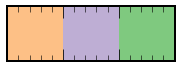

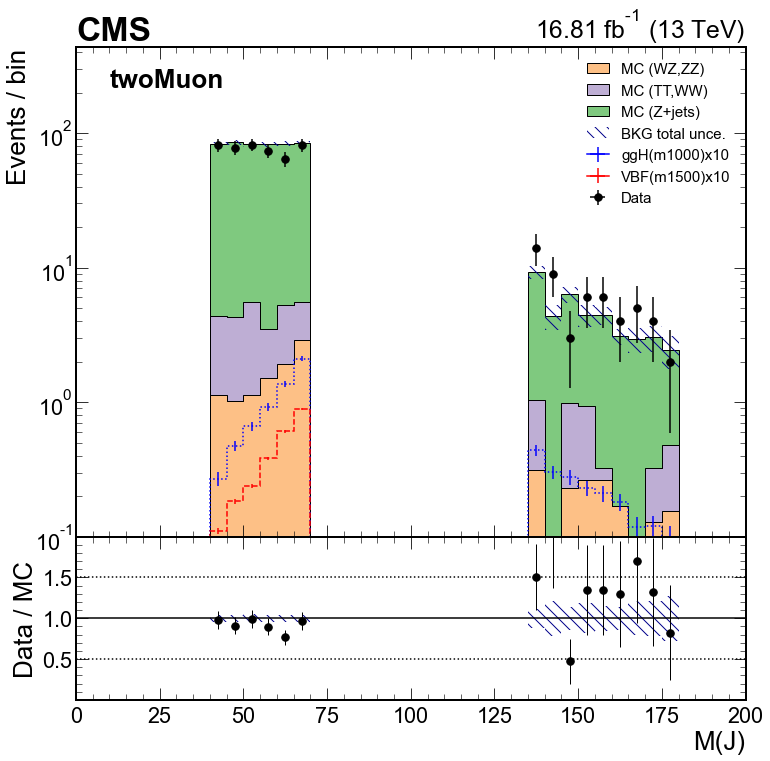

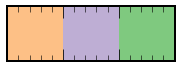

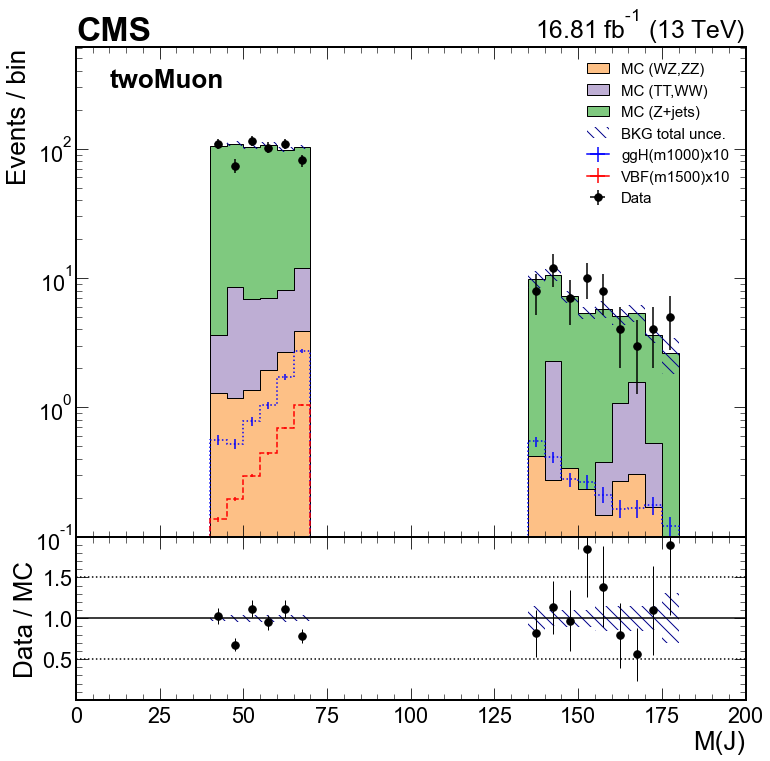

In [16]:
####======================================draw single var============================================
#set draw var
var = 'massmerged'
nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
edge = np.linspace(xmin, xmax, nbins+1)
if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
    islogY = True
else:
    islogY = True
        
#fill histo 
bkg_hists = {}; Data_hist = {}; signal_hists = {}
for cat in cats:
    bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None; signal_hists[cat] = []
    if cat =='isEE':
        text = 'twoEle'
    elif cat =='isMuMu':
        text = 'twoMuon'
    for sample in Samples_lists:
        print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array_cut[cat][sample]
            #retray weight and apply paritcleNet weight
            weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
            if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
            elif sample.find('DY')!=-1:
                sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
            elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
            else:
                sf_Net = ak.ones_like(temp_array['EventWeight'])
            weights = weights*sf_Net
                
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
            if sample.find('DY')!=-1:
                if (bkg_hists[cat])[2]==None:
                    (bkg_hists[cat])[2] = temp_hist
                else:
                    (bkg_hists[cat])[2]+=temp_hist
            if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                if (bkg_hists[cat])[1]==None:
                    (bkg_hists[cat])[1] = temp_hist
                else:
                    (bkg_hists[cat])[1]+=temp_hist
            if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                if (bkg_hists[cat])[0]==None:
                    (bkg_hists[cat])[0] = temp_hist
                else:
                    (bkg_hists[cat])[0]+=temp_hist
        else:
            temp_array = data_array_cut[cat]
            weights = np.ones_like(temp_array['EventWeight'])
            print(f'data weight  = {weights}')
            Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        
    for sample in signal_lists:
        temp_array = signal_array_cut[cat][sample]
        weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
        sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
        weights = weights*sf_Net
        temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        signal_hists[cat].append(temp_hist)
    
print("Fill done")

#draw var
for cat in cats:
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    ##================================ Upper histogram panel=========================================
    ax = f.add_subplot(gs[0])
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    
    ##BACKGRUND
    #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    bkg_err = get_err(bkg_hist)
    #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

    if plot_unce:
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
        ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0);
    
    ##SIGNAL
    colors = ['blue', 'red']
    plot_hist(signal_hists[cat],label=[ var for var in ['ggH(m1000)x10','VBF(m1500)x10']],linestyle=[style for style in [':','--']], color=[color for color in colors])
    
    ##DATA
    data_err = get_err(Data_hist[cat])
    data = Data_hist[cat].values()
    #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    if islogY:
        ax.set(yscale = "log")
        ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
    else:
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.set_ylim(0, 1.5*max(data))
        
    ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold')
    hep.plot.yscale_legend
    ax.legend(fontsize=15)

    ##==========================================Ratio panel========================
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
    ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
    ratio=np.nan_to_num((data/bkg_tot),nan=-1)
    ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
    hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    if plot_unce:
        ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
        ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
        ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        #ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

[INFO] it is pt2l plot
Fill done pt2l
[INFO] it is isEE plot
[INFO] it is isMuMu plot
[INFO] it is mass2l plot
Fill done mass2l
[INFO] it is isEE plot
[INFO] it is isMuMu plot
[INFO] it is particleNetZvsQCD plot
Fill done particleNetZvsQCD
[INFO] it is isEE plot
[INFO] it is isMuMu plot
[INFO] it is massmerged plot
Fill done massmerged
[INFO] it is isEE plot


/tmp/ipykernel_14722/4065892066.py:124: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_14722/4065892066.py:125: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_14722/4065892066.py:129: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_14722/4065892066.py:130: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


[INFO] it is isMuMu plot


/tmp/ipykernel_14722/4065892066.py:124: RuntimeWarning: invalid value encountered in true_divide
  ratio=np.nan_to_num((data/bkg_tot),nan=-1)
/tmp/ipykernel_14722/4065892066.py:125: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
/tmp/ipykernel_14722/4065892066.py:129: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
/tmp/ipykernel_14722/4065892066.py:130: RuntimeWarning: invalid value encountered in true_divide
  ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)


[INFO] it is ptmerged plot
Fill done ptmerged
[INFO] it is isEE plot
[INFO] it is isMuMu plot


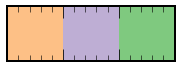

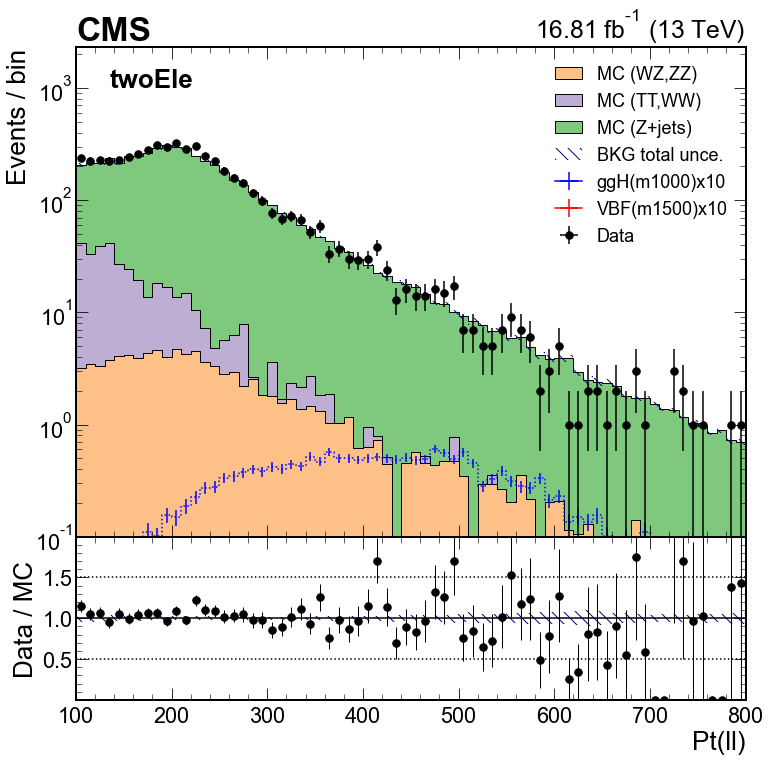

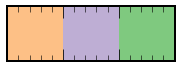

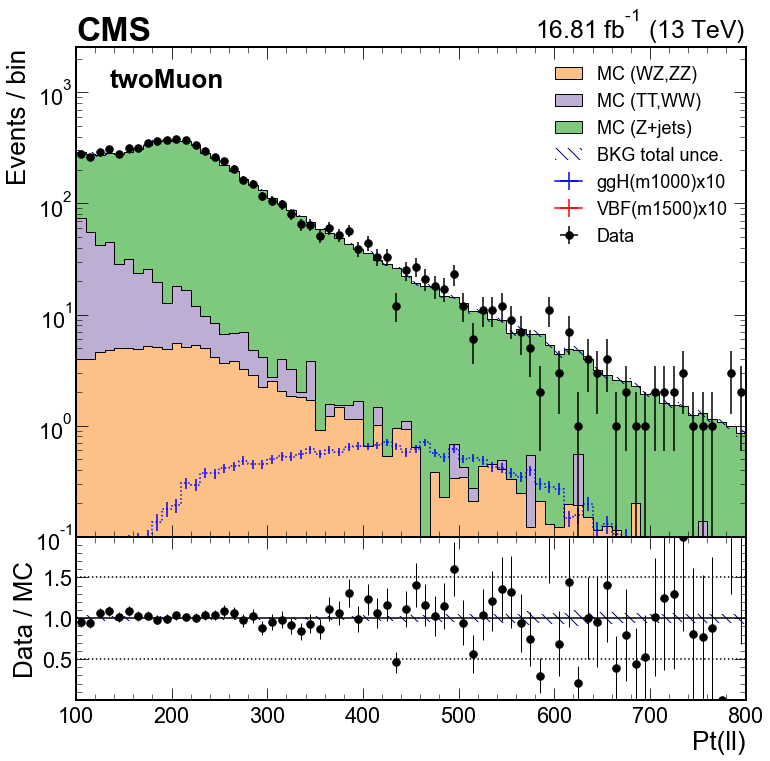

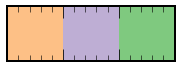

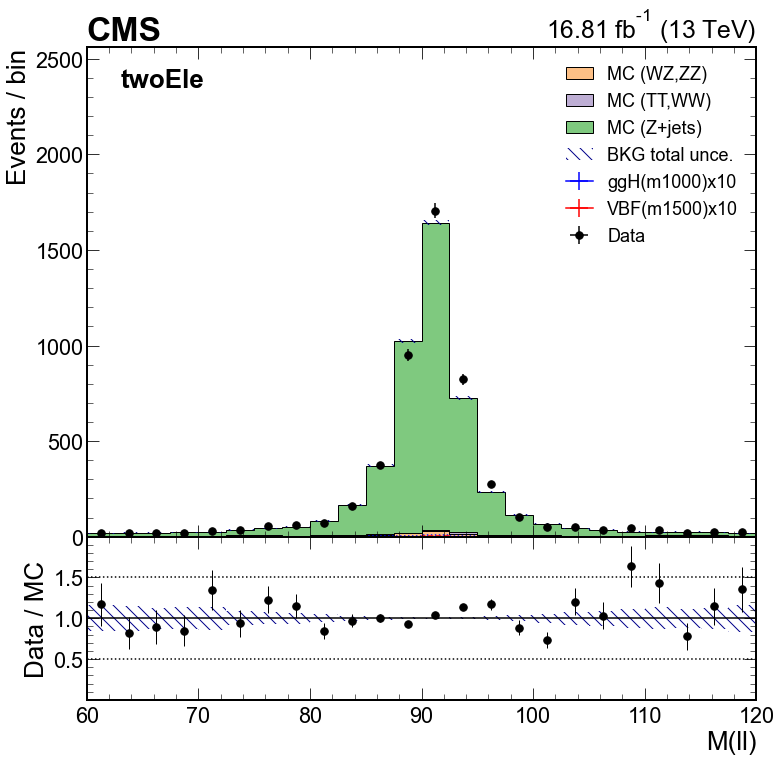

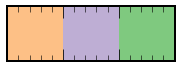

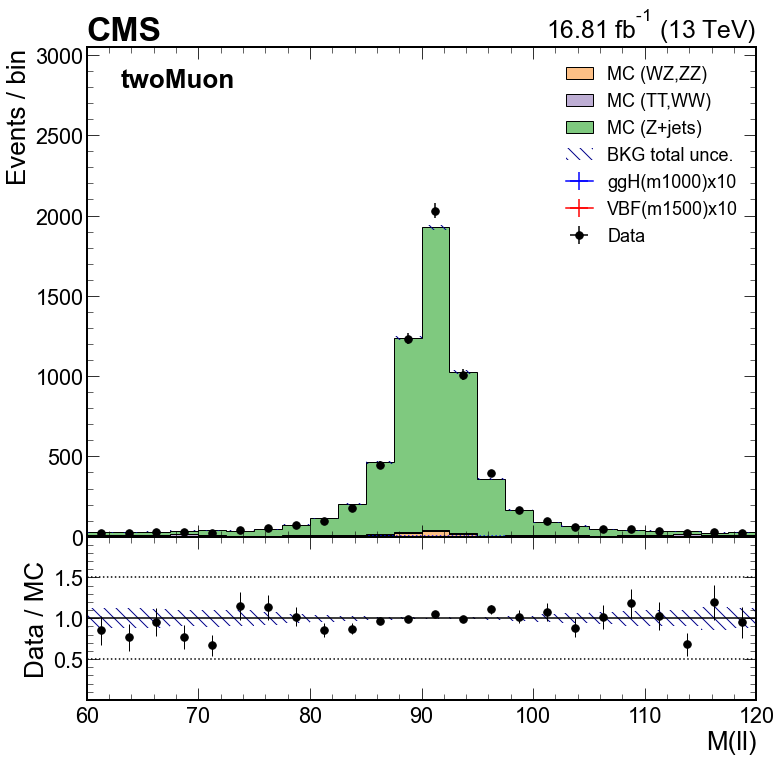

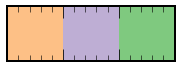

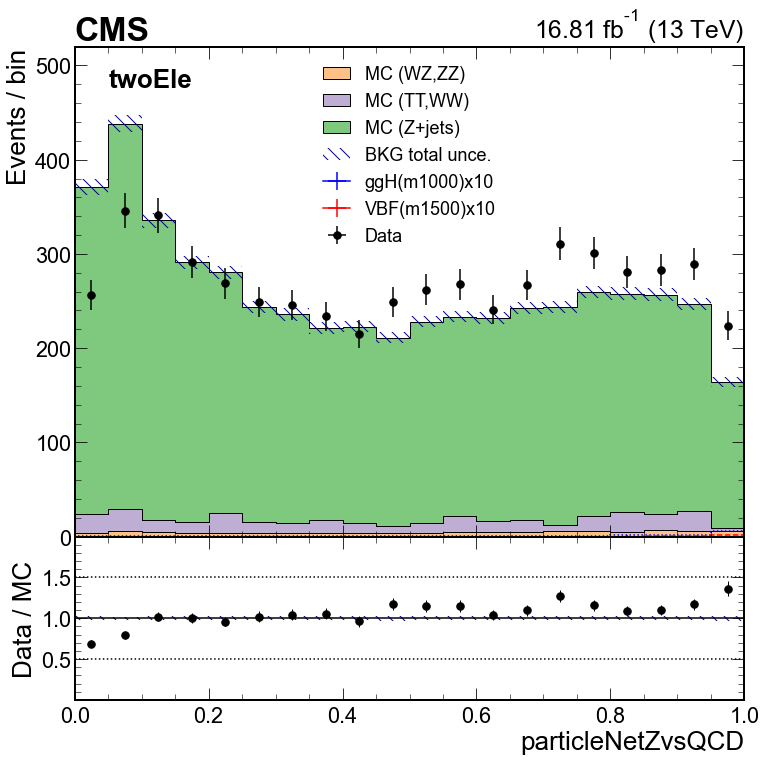

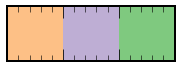

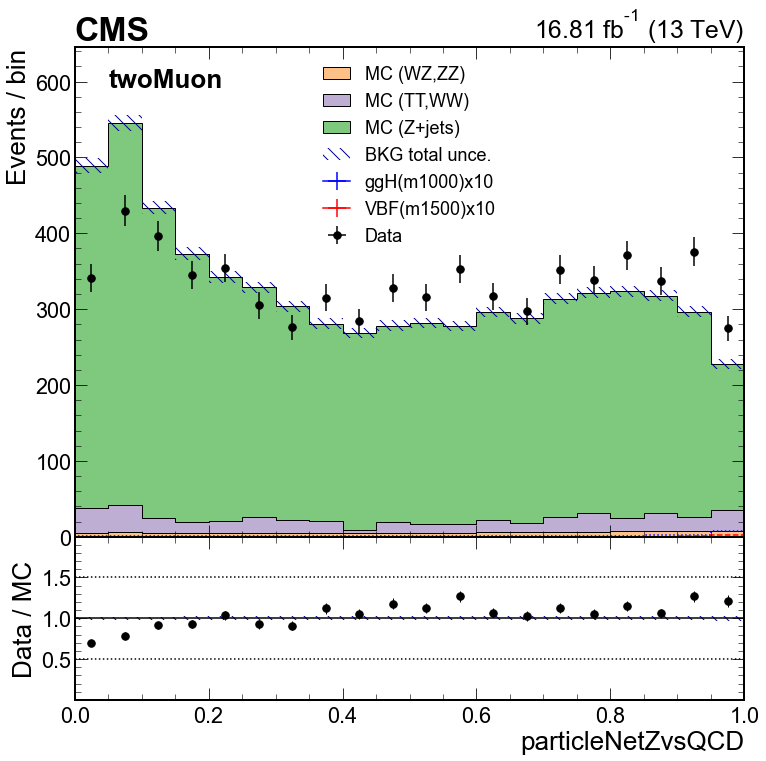

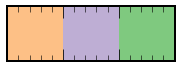

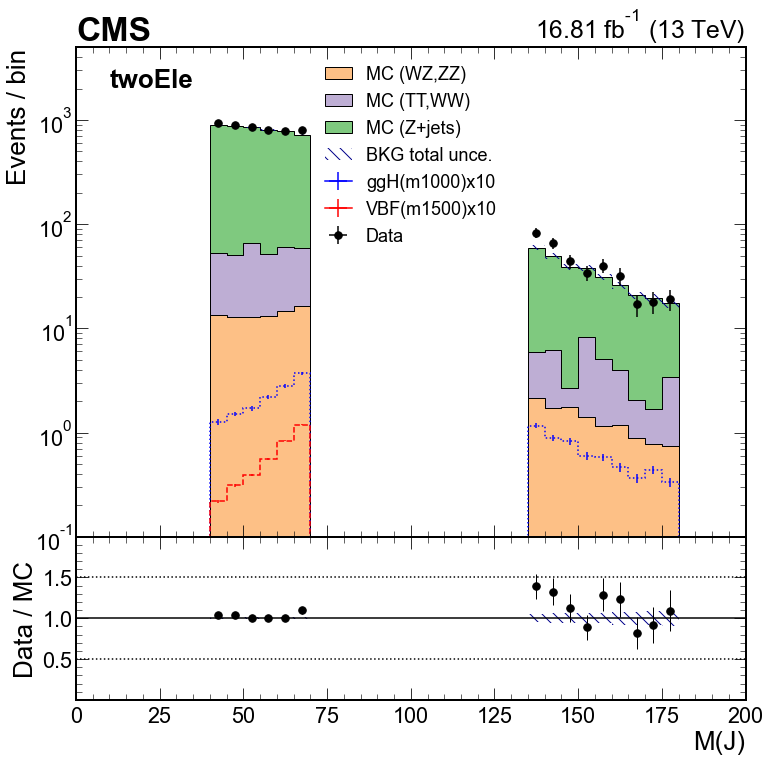

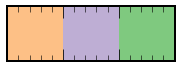

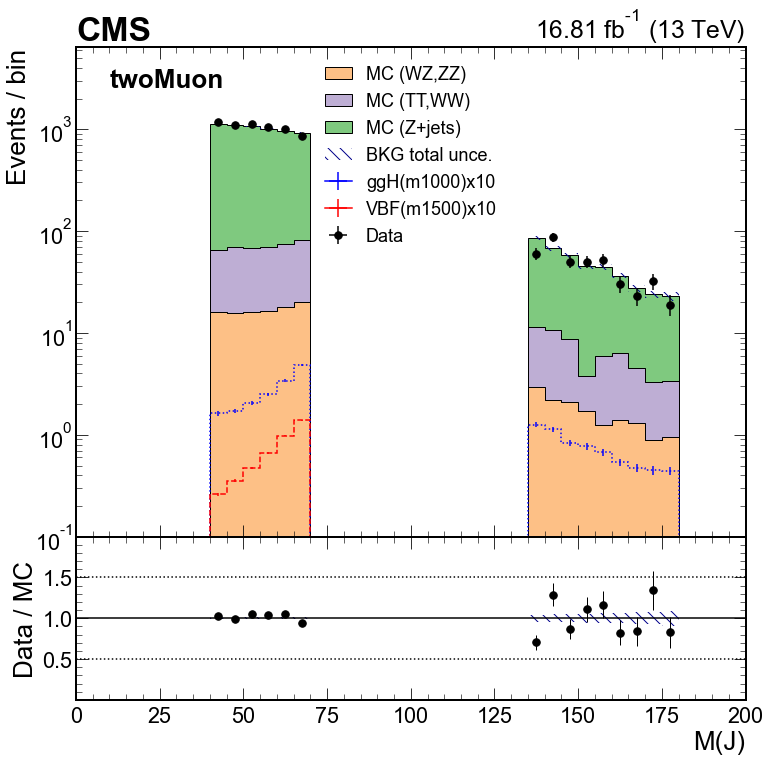

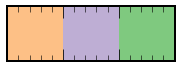

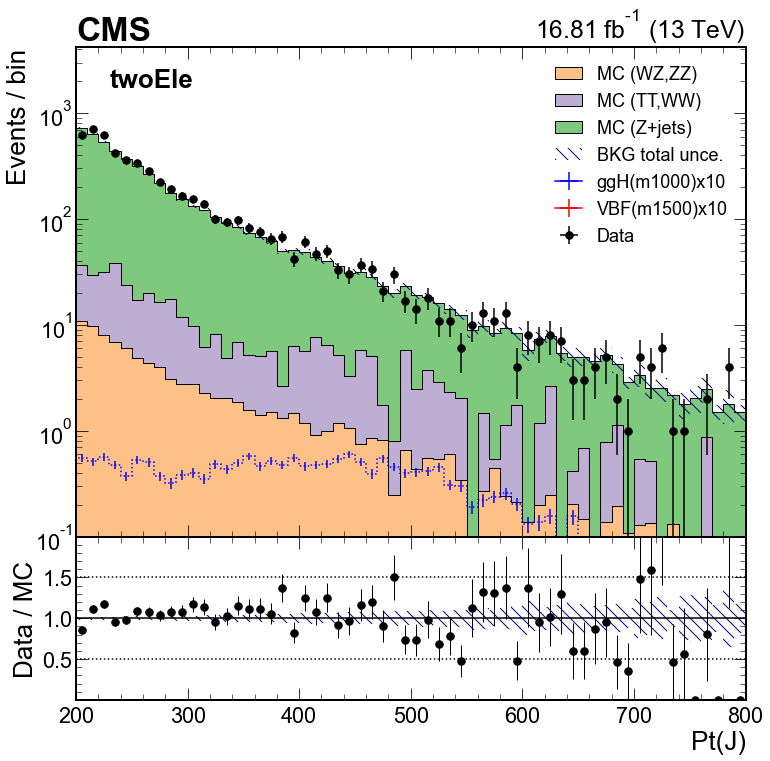

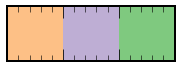

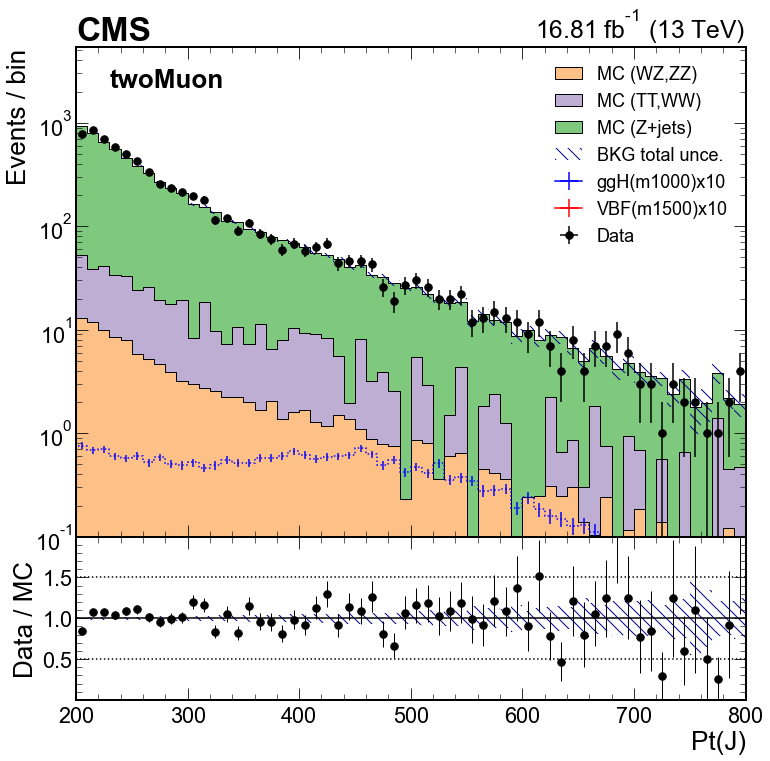

In [49]:
####======================================Draw lists of  varbs============================================
####======================================And save plots================================================
#set draw var
varbs = ['pt2l','mass2l','particleNetZvsQCD','massmerged','ptmerged']
#varbs = ['pt2l','mass2l','mass2jet','pt2jet','massmerged','ptmerged']
#varbs = ['KD_jjVBF']
isMerged = False
for var in varbs:
    print(f"[INFO] it is {var} plot")
    nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
    edge = np.linspace(xmin, xmax, nbins+1)
    if var.find('pt')!=-1 or var.find('massmerged')!=-1 :
        islogY = True
    else:
        islogY = False
        
    #fill histo 
    bkg_hists = {}; Data_hist = {}; signal_hists = {}
    for cat in cats:
        bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None; signal_hists[cat] = []
        for sample in Samples_lists:
            #print(f"This is {sample} in {cat}")
            if sample!='Data':
                temp_array = bkg_array_cut[cat][sample]
                weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
                if(isMerged):
                    if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                        sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
                    elif sample.find('DY')!=-1:
                        sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
                    elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
                    else:
                        sf_Net = ak.ones_like(temp_array['EventWeight'])
                    weights = weights*sf_Net
            
                temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
                if sample.find('DY')!=-1:
                    if (bkg_hists[cat])[2]==None:
                        (bkg_hists[cat])[2] = temp_hist
                    else:
                        (bkg_hists[cat])[2]+=temp_hist
                if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                    if (bkg_hists[cat])[1]==None:
                        (bkg_hists[cat])[1] = temp_hist
                    else:
                        (bkg_hists[cat])[1]+=temp_hist
                if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                    if (bkg_hists[cat])[0]==None:
                        (bkg_hists[cat])[0] = temp_hist
                    else:
                        (bkg_hists[cat])[0]+=temp_hist
            else:
                temp_array = data_array_cut[cat]
                weights = np.ones_like(temp_array['EventWeight'])
                Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        
        for sample in signal_lists:
            temp_array = signal_array_cut[cat][sample]
            weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 100
            if(isMerged):
                sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
                weights = weights*sf_Net
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            signal_hists[cat].append(temp_hist)
    
    print(f"Fill done {var}")

    #draw var
    for cat in cats:
        if cat =='isEE':
            text = 'twoEle'
        elif cat =='isMuMu':
            text = 'twoMuon'
        print(f"[INFO] it is {cat} plot")
        plot_unce = True
        set_sns_color(color_order_bkg)
        f = plt.figure(figsize=(12,12))
        gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
        ##================================ Upper histogram panel=========================================
        ax = f.add_subplot(gs[0])
        hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
        ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    
        ##BACKGRUND
        #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
        plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
        bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
        bkg_tot = bkg_hist.values()
        bkg_err = get_err(bkg_hist)
        #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

        if plot_unce:
            #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
            ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
        ax.set_ylabel('Events / bin', ha='right', y=1.0);
    
        ##SIGNAL
        colors = ['blue', 'red']
        plot_hist(signal_hists[cat],label=[ var for var in ['ggH(m1000)x10','VBF(m1500)x10']],linestyle=[style for style in [':','--']], color=[color for color in colors])
    
        ##DATA
        data_err = get_err(Data_hist[cat])
        data = Data_hist[cat].values()
        #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
        plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
        if islogY:
            ax.set(yscale = "log")
            ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
        else:
            ax.set_ylim(0, ax.get_ylim()[1])
            ax.set_ylim(0, 1.5*max(data))
        ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold')
        hep.plot.yscale_legend
        ax.legend(fontsize=18)

        ##==========================================Ratio panel========================
        ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
        ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
        ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
        ratio=np.nan_to_num((data/bkg_tot),nan=-1)
        ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
        hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
        #hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
        if plot_unce:
            ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
            ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
            ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
            #ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
            
        plt.savefig(f'./plots/Merged/withoutNetcut/{var}_{text}.png')

In [39]:
for cat in cats:
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    
    ## Upper histogram panel
    ax = f.add_subplot(gs[0])
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0)
    #content = hist.values()
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    #hep.histplot(content, bins=edge, label="MC",histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    #bkg_err = get_err(bkg_hist)
    bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)
    edge = (Data_hist[cat].axes.edges)[0]
    if plot_unce:
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
        ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0);

    #data, data_errh, data_errl = Data_hist.yvalues, Data_hist.yerrorshigh, Data_hist.yerrorslow
    data_err = get_err(Data_hist[cat])
    data = Data_hist[cat].values()
    hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylim(0, 1.5*max(data))
    #ax.set(yscale = "log")
    ax.legend(fontsize=12)

    ## Ratio panel
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
    ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
    #ratio = replace_nan(data/bkg_tot,isunc = False)
    #ratio_err = replace_nan(data_err/bkg_tot,isunc = False)
    ratio=np.nan_to_num((data/bkg_tot),nan=0)
    ratio_err = np.nan_to_num((data_err/bkg_tot),nan=0)
    hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_tot,bins=edge, histtype='fill', linewidth=1)
    #ax1.fill_between(edge, (data/bkg_tot-bkg_err).tolist()+[0], (data/bkg_tot+bkg_err).tolist()+[0], step = "pre",facecolor='none', linewidth=0) ## draw bkg unce.
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_tot,bins=edge, color='k')
    if plot_unce:
        ratio_unc_low =replace_nan(((bkg_tot-bkg_err)/bkg_tot),isunc = True)
        ratio_unc_up = replace_nan(((bkg_tot+bkg_err)/bkg_tot),isunc = True)
        ratio_unc_low = 
        ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.


SyntaxError: invalid syntax (2149737806.py, line 53)

This is DY_pt50To100 in isEE
This is DY_pt100To250 in isEE
This is DY_pt250To400 in isEE
This is DY_pt400To650 in isEE
This is DY_pt650ToInf in isEE
This is TTJets in isEE
This is WZTo2Q2L in isEE
This is ZZTo2Q2L in isEE
This is WWTo2L2Nu in isEE
This is Data in isEE
This is DY_pt50To100 in isMuMu
This is DY_pt100To250 in isMuMu
This is DY_pt250To400 in isMuMu
This is DY_pt400To650 in isMuMu
This is DY_pt650ToInf in isMuMu
This is TTJets in isMuMu
This is WZTo2Q2L in isMuMu
This is ZZTo2Q2L in isMuMu
This is WWTo2L2Nu in isMuMu
This is Data in isMuMu
Fill done
[INFO] it is isEE plot
[INFO] it is isMuMu plot


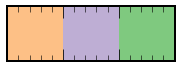

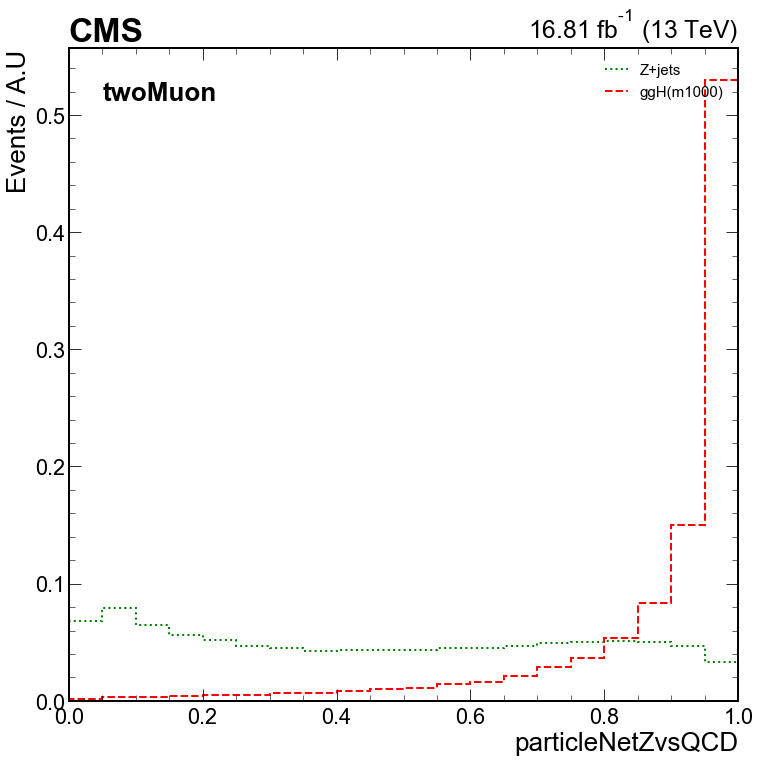

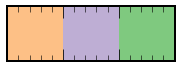

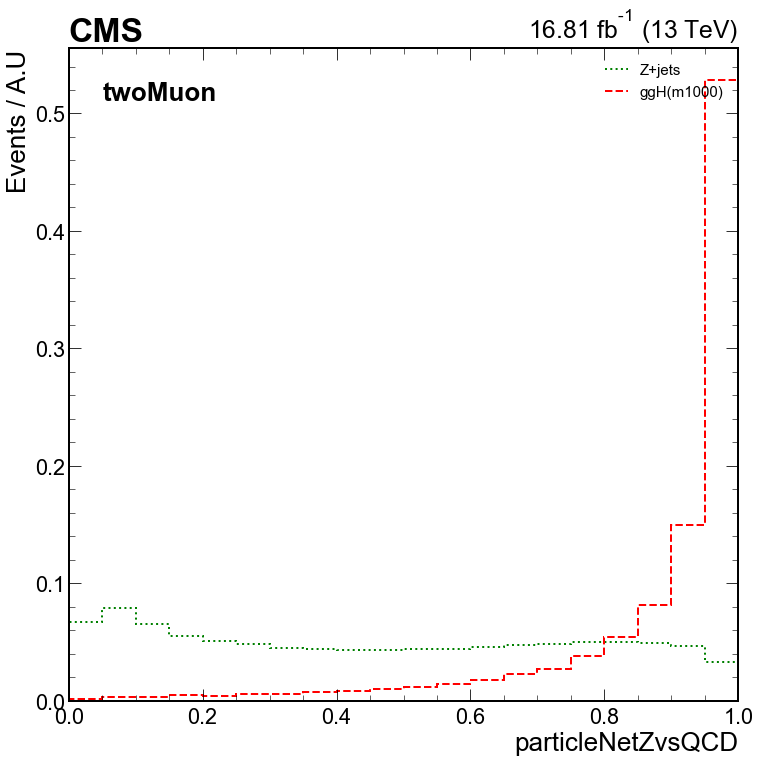

In [69]:
####======================================draw single var============================================
#set draw var
var = 'particleNetZvsQCD'
nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
edge = np.linspace(xmin, xmax, nbins+1)
if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
    islogY = True
else:
    islogY = True
        
#fill histo 
bkg_hists = {}; Data_hist = {}; signal_hists = {}
for cat in cats:
    if cat =='isEE':
        text = 'twoEle'
    elif cat =='isMuMu':
        text = 'twoMuon'
    bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None; signal_hists[cat] = []
    for sample in Samples_lists:
        print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array_cut[cat][sample]
            #retray weight and apply paritcleNet weight
            #tot_events = temp_array
            #weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
            weights = ak.ones_like(temp_array['EventWeight'])
            #if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
            #    sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD')
            #elif sample.find('DY')!=-1:
            #    sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
            #elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
            #    sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
            #else:
            #    sf_Net = ak.ones_like(temp_array['EventWeight'])
            #weights = weights*sf_Net
                
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
            
            if sample.find('DY')!=-1:
                if (bkg_hists[cat])[2]==None:
                    (bkg_hists[cat])[2] = temp_hist
                else:
                    (bkg_hists[cat])[2]+=temp_hist
            if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                if (bkg_hists[cat])[1]==None:
                    (bkg_hists[cat])[1] = temp_hist
                else:
                    (bkg_hists[cat])[1]+=temp_hist
            if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                if (bkg_hists[cat])[0]==None:
                    (bkg_hists[cat])[0] = temp_hist
                else:
                    (bkg_hists[cat])[0]+=temp_hist
        #else:
        #    temp_array = data_array_cut[cat]
        #    weights = np.ones_like(temp_array['EventWeight'])
        #    print(f'data weight  = {weights}')
        #    Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        
    for sample in signal_lists:
        temp_array = signal_array_cut[cat][sample]
        #weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
        weights = ak.ones_like(temp_array['EventWeight'])
        #sf_Net = GetParticleNetSignalSF(temp_array,tagger='ZvsQCD')
        #weights = weights*sf_Net
        temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        signal_hists[cat].append(temp_hist)
    
print("Fill done")

#draw var
for cat in cats:
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    #gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    ##================================ Upper histogram panel=========================================
    ax = f.add_subplot()
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_ylabel('Events / A.U', ha='right', y=1.0)
    
    ##BACKGRUND
    #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    
    #plot_hist(bkg_hists[cat][2].values()/bkg_hists[cat][2].sum(),label='Z+jets', edgecolor='k', linewidth=1) ## draw MC
    descity  = bkg_hists[cat][2].view(flow=False).value/sum(bkg_hists[cat][2].view(flow=False).value)
    bins = bkg_hists[cat][2].axes[0].edges
    hep.histplot(descity,bins=bins,label='Z+jets', linestyle=':',edgecolor='green', linewidth=2)
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    bkg_err = get_err(bkg_hist)
    #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

    #if plot_unce:
    #    ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
    #    ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    #ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    #ax.set_ylabel('Events / bin', ha='right', y=1.0);
    
    ##SIGNAL
    colors = ['blue', 'red']
    descity = signal_hists[cat][0].view(flow=False).value/sum(signal_hists[cat][0].view(flow=False).value)
    hep.histplot(descity,bins = bins,label='ggH(m1000)',linestyle='--', color='red',linewidth=2)
    
    ##DATA
    #data_err = get_err(Data_hist[cat])
    #data = Data_hist[cat].values()
    #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    #plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    #if islogY:
    #    ax.set(yscale = "log")
    #    ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
    #else:
    #    ax.set_ylim(0, ax.get_ylim()[1])
    #    ax.set_ylim(0, 1.5*max(data))
    #hep.plot.yscale_legend
    ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold')
    ax.set_xlim(xmin, xmax); ax.set_xlabel(bininfo[var][3], ha='right', x=1.0)
    ax.legend(fontsize=15)

    ##==========================================Ratio panel========================
    r'''
    ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
    ax1.set_xlabel(bininfo[var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
    ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
    
    ratio=np.nan_to_num((data/bkg_tot),nan=-1)
    ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
    hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    #hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
    if plot_unce:
        ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
        ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
        ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        #ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        '''

In [43]:
de = bkg_hists[cat][2].view(flow=False).value/sum(bkg_hists[cat][2].view(flow=False).value)

In [49]:
de[1]

0.08534090896641033

In [46]:
bkg_hists[cat][2].reset(de)

TypeError: reset() takes 1 positional argument but 2 were given

In [36]:
sum(bkg_hists[cat][2].view(flow=False).value)

763848.0

In [11]:
def plot_hist(hists, normed=False, **kwargs):
    r"""Plot the histogram in the type of boost_histogram
    """
    
    if not isinstance(hists, (list, tuple)):
        hists = [hists]
    content = [h.view(flow=False).value for h in hists]
    bins = hists[0].axes[0].edges
    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    if 'yerr' in kwargs:
        yerr = kwargs.pop('yerr')
    else:
        yerr = [np.sqrt(h.view(flow=False).variance) for h in hists]
    if normed:
        for i in range(len(content)):
            contsum = sum(content[i])
            content[i] /= contsum
            yerr[i] /= contsum
    if len(hists) == 1:
        content, yerr = content[0], yerr[0]
    hep.histplot(content, bins=bins, yerr=yerr, **kwargs)

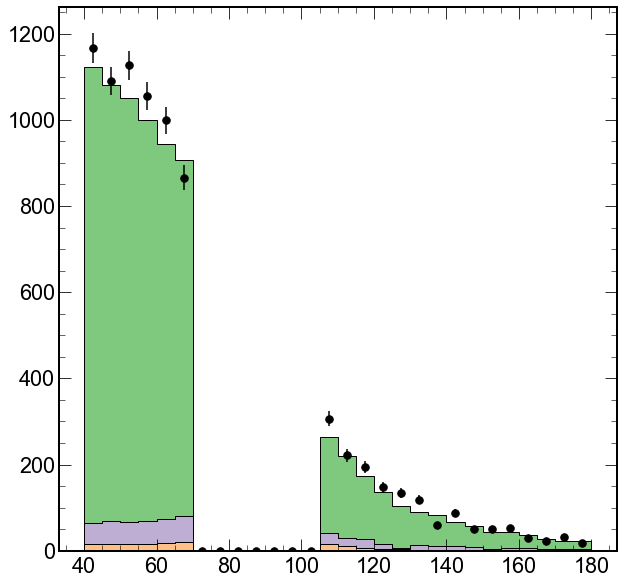

In [311]:
plot_hist(bkg_hists[cat], bins=edge,label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']], histtype='fill', edgecolor='k', linewidth=1, stack=True)
plot_hist(Data_hist[cat], bins=edge, label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5)

In [32]:
arr  = np.array([1,2,34,5])
arr

array([ 1,  2, 34,  5])

In [33]:
arr_one = np.ones_like(arr)
arr_one

array([1, 1, 1, 1])

In [34]:
uproot

'isEE'